# Kaggle Titanic 项目

数据科学竞赛工作流**七个阶段**:  
1. 问题定义（Problem Definition）  
    * 明确要解决的问题，例如：预测哪些乘客能在泰坦尼克号沉船事件中幸存。
2. 获取数据（Acquire Data）    
    * 下载并理解训练集（含标签）和测试集（不含标签）。
3. 数据清洗与准备（Preprocessing/Wrangle）  
    * 处理缺失值、异常值、标准化数据、构造新特征。
4. 分析与探索（EDA）  
    * 利用统计和可视化工具发现规律，比如哪些特征和生存率强相关。
5. 建模与预测（Modeling）  
    * 使用机器学习模型（逻辑回归、随机森林、XGBoost 等）训练和预测。
6. 可视化与汇报（Visualization）  
    * 用图表和文字展示过程与结果，方便他人理解。
7. 提交结果（Submission）  
    * 将预测结果提交到 Kaggle 平台进行评分。

## Problem Definition  

问题背景（Titanic 竞赛）

1912 年 4 月 15 日，泰坦尼克号首航撞上冰山沉没。2224 人中仅 32% 幸存。

主要原因之一：救生艇数量不足。

虽然生存有运气成分，但某些群体更可能幸存：女性、儿童、上层阶级。

Kaggle 问题：能否用训练集数据预测测试集乘客是否幸存？  

---

在工作流中，我们主要追求以下目标：

1. 分类（Classifying）
    * 把样本划分为“幸存/未幸存”，并理解不同类别的特征差异。
2. 相关性分析（Correlating）
    * 哪些特征（年龄、性别、船票等级等）与生存率显著相关？特征之间是否相关？
3. 数据转换（Converting）
    * 将类别特征（如“male/female”）转换为数值（0/1），方便建模。
4. 补全（Completing）
    * 填补缺失值（如年龄缺失时，用中位数或预测模型填补）。
5. 纠正（Correcting）
    * 修正或删除错误数据、异常值；必要时丢弃不相关的特征。
6. 特征工程（Creating）
    * 基于已有数据创造新特征，例如：从姓名中提取称谓（Mr/Mrs/Miss）作为社会地位的 proxy。
7. 可视化（Charting）
    * 使用直方图、散点图、条形图等方式，帮助解释和呈现数据规律。

In [2]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

## Acquire data

从 Kaggle 上下载数据集，上传至 Google Drive。  
Path
* `/content/drive/MyDrive/Colab Notebooks/Machine Learning/Titanic Project/data/train.csv`
* `/content/drive/MyDrive/Colab Notebooks/Machine Learning/Titanic Project/data/test.csv`

In [3]:
from google.colab import drive

# 挂载 Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 读取训练和测试集，得到 DataFrame
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine Learning/Titanic Project/data/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine Learning/Titanic Project/data/test.csv')

# 这不是把两个表“合并成一个表”，只是打包成列表以便循环
combine = [train_df, test_df]

## EDA

### Analyze by describing data  

在数据科学项目的早期阶段，我们常用 pandas 的方法来快速描述数据集，回答几个关键问题：
1. **数据集里有哪些特征（features）？**  

In [5]:
# 获取表的列名集合
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


2. **哪些特征是 类别型（categorical）？**  
* 类别型特征：值表示“类别”，而不是数值大小。
    * 在 Titanic 里：
        * **Survived**（幸存与否，0/1）
        * **Sex**（男/女）
        * **Embarked**（登船港口：C/Q/S）
* 类别型里又可分为：
    * Nominal：无顺序，如 Sex、Embarked。
    * Ordinal：有顺序的类别，如 Pclass（1 等舱 > 2 等舱 > 3 等舱）。

分类很重要，因为不同类型的特征适合不同的统计方法和图表。

3. **哪些特征是 数值型（numerical）？**
* 数值型特征：值是数量，可以计算平均值、标准差等。
    * 在 Titanic 里：
        * **Continuous**：Age（年龄）、Fare（票价）。
        * **Discrete**：SibSp（兄弟姐妹/配偶数）、Parch（父母/子女数）。

连续 vs 离散也影响可视化选择，比如直方图 vs 条形图。

In [6]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


4. **哪些特征是 混合数据类型（Mixed Data Types）？**  
* **定义**：在同一列（feature）里同时存在数字和字母/符号。这种情况通常需要 **数据纠正（Correcting）**。
* 在 Titanic 数据里：
    * **Ticket**（船票号）：既有纯数字（如 12345），也有字母+数字组合（如 PC 17599）。
    * **Cabin**（舱位）：通常是字母+数字组合（如 C85），有时还会有多个舱位用空格分隔。

这些列如果直接拿去建模，会导致混乱，需要先处理，比如：
* Ticket → 提取数字部分 / 提取前缀 / 简化成分组
* Cabin → 提取甲板字母（A, B, C…）  

5. **哪些特征可能包含 错误或拼写问题（errors/typos）？**
* 在大型数据集里很难人工检查，但在小数据里可以抽样看。
* 在 Titanic 数据里：
    * **Name（姓名）** 特征可能有不一致的写法：
        * 有的带称谓（Mr, Mrs, Miss）
        * 有的带括号（表示昵称或别名）
        * 有的带引号或特殊符号
这些“不一致”不算严格的错误，但可能影响特征工程，需要统一处理：
* 提取称谓（Title）作为新特征
* 去掉括号里的昵称
* 标准化格式

In [7]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


6. **哪些特征包含 空值（blank/null/empty）？**  
这些需要在 数据纠正（Correcting） 阶段处理。
* **训练集（train dataset）** 缺失值数量最多的特征依次是：
    1. Cabin（舱位） → 缺失非常多（大部分为空）
    2. Age（年龄） → 有部分乘客缺失
    3. Embarked（登船港口） → 少数缺失

* **测试集（test dataset）** 缺失的主要是：
    1. Cabin
    2. Age

所以在清洗数据时，要特别关注 Cabin / Age / Embarked 这三列。  

7. **各个特征的数据类型（data types）**  
这一步是为了帮助后续 转换（Converting）。
* **数值型（integer 或 float）**
    * 训练集有 7 个数值型特征
    * 测试集有 6 个数值型特征
    （因为测试集少了 Survived 这一列标签）
* **字符串型（object/string）**
    * 5 个特征属于字符串，比如：Name、Sex、Ticket、Cabin、Embarked

In [8]:
"""
显示 train_df 的整体信息：
    每一列的名字
    非空值（non-null）的数量
    列的数据类型（int, float, object）
    总行数、总列数
    内存占用情况
这是检查 数据类型 和 缺失值数量 的最快方法。
"""
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

8. **数值型特征的分布情况**  
* 样本量
    * 训练集中共有 891 个样本，大约是船上实际总人数 2,224 人的 40%。
* Survived（是否幸存）
    * 这是一个类别型二值特征（0 = 未幸存，1 = 幸存）。
    * 训练集中幸存率约 38%，与真实历史上的 32% 相对接近 → 数据有代表性。
* Parch（父母/子女数量）
    * 超过 75% 的乘客没有带父母或子女同行（值为 0）。
* SibSp（兄弟姐妹/配偶数量）
    * 大约 30% 的乘客有兄弟姐妹或配偶随行。
* Fare（票价）
    * 票价差异非常大：大部分人票价较低，但极少数人（<1%）支付了高达 $512 的高价票 → 存在明显的极端值。
* Age（年龄）
    * 绝大多数乘客在 20–40 岁之间。
    * 仅有极少数（<1%）的老人年龄在 65–80 岁。

In [9]:
# 默认不写 include 时，describe() 只会总结数值列
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


9. **分类特征的分布情况（Categorical Features Distribution）**  
* Name（姓名）
    * 唯一值（unique）数量 = 总行数（891）
    * 说明 每个名字都不重复，可以作为唯一标识，但不适合作为建模特征。
* Sex（性别）
    * 只有两种取值：male / female
    * 男性占比 65%（577/891），女性占比约 35%
    * 可直接用于分析生存率差异。
* Cabin（舱位）
    * 有重复值：部分乘客共享同一个舱位（例如家庭或结伴出行）。
    * 缺失值很多（大部分为空）。
    * 但提取舱位首字母（A、B、C…）能表示甲板位置，有时对生存率有用。
* Embarked（登船港口）
    * 共有 3 种取值：C（Cherbourg）、Q（Queenstown）、S（Southampton）。
    * 大多数乘客从 S 港登船（top=S）。
* Ticket（船票号）
    * 有 较高比例的重复值（22%），即多个乘客使用相同票号（通常是一起订票的家庭或团体）。
    * 总共 891 行数据，unique=681 → 有 210 人共享票号。

In [10]:
# 只对“文本/类别型列”做统计性概要描述
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Dooley, Mr. Patrick",male,347082,G6,S
freq,1,577,7,4,644


**基于数据分析的假设 (Assumptions based on data analysis)**

在数据探索之后，我们通常会提出一些假设，并在后续建模和验证中检验这些假设。

---

**Correlating（相关性假设）**
* 我们希望知道：**每个特征和生存率的相关性**如何。
* 在项目早期先做快速相关性判断，后续再用模型结果进行验证。

---

**Completing（补全缺失值）**
* Age（年龄）：和生存率有明显相关性，因此需要补全缺失值。
* Embarked（登船港口）：可能和生存率或其他特征相关，也需要补全缺失值。

---

**Correcting（修正或丢弃特征）**
* Ticket（票号）：重复率高（22%），且和生存率相关性可能不大 → 考虑丢弃。
* Cabin（舱位）：缺失值太多 → 考虑丢弃。
* PassengerId（乘客编号）：仅是标识，不影响生存率 → 丢弃。
* Name（姓名）：格式不统一，不直接贡献预测 → 原始列可能丢弃。

---

**Creating（新特征工程）**
* Family 家庭规模：由 Parch + SibSp 计算总家庭人数。
* Title 称谓：从 Name 提取称谓（如 Mr, Mrs, Miss），作为社会地位 proxy。
* Age bands 年龄分段：把连续变量 Age 分成区间（儿童、青年、老年），转为有序类别特征。
* Fare range 票价区间：对票价分箱，缓解极端值影响。

---

**Classifying（基于问题背景的分类假设）**
* 性别：女性（Sex=female）更可能幸存。
* 年龄：儿童（Age 较小）更可能幸存。
* 社会阶层：上层舱位（Pclass=1）的乘客更可能幸存。

### Analyze by pivoting features  

为了验证之前的数据观察和假设，我们可以通过 特征与目标值（Survived）之间的透视表 来快速分析相关性。  
注意：
* 只能用没有缺失值的特征。
* 更适合用类别型 (categorical)、有序型 (ordinal) 或 离散型 (discrete) 特征。

---

**Pclass（客舱等级）**
* 观察结果：Pclass=1 和 Survived 的相关性显著（>0.5）。
* 说明头等舱乘客的生存率明显更高。
* 决策：将 Pclass 特征保留在模型中。

---

**Sex（性别）**
* 验证了我们最初的假设：
    * 女性乘客（Sex=female）的生存率高达 74%。
    * 远高于男性。
* 这是一个非常强的分类特征 → 必须保留。

---

**SibSp（兄弟姐妹/配偶数量） & Parch（父母/子女数量）**
* 这两个特征在某些取值下，与 Survived 的相关性接近 0。
* 单独使用时可能不稳定。
* 更好的方式：
    * 将它们组合，衍生出一个新特征 FamilySize = SibSp + Parch + 1。
    * 或进一步构造“是否独自旅行”特征（FamilySize=1）。

In [11]:
# 按客舱等级 Pclass 分组，计算各等级的平均生存率，并按生存率降序排序
# as_index=False：让分组键 Pclass 保留为普通列（而不是作为行索引）
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [12]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [13]:
train_df[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [14]:
train_df[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


### Analyze by visualizing data  

我们可以使用 可视化 来验证之前的一些假设。

#### Correlating numerical features  

* 直方图 (Histogram) 是分析连续型数值变量（如 Age 年龄）的好工具。

* 通过把数据分成区间（bins/bands），我们能观察不同年龄段的分布情况以及对应的生存率。

* 横轴（x-axis）表示样本数量（即不同区间内的乘客人数）。

直方图能回答类似的问题：

* 婴儿（Age <= 4）是否生存率更高？

* 年轻人和老年人群体的生存情况是否不同？

---

**观察结果 (Observations)**

1. 婴儿（≤4 岁）生存率很高

2. 最年长的乘客（80 岁）幸存

3. 大量 15–25 岁的乘客没有幸存

4. 大部分乘客集中在 15–35 岁之间

---

**决策 (Decisions)**

基于上面的观察，我们得出以下行动方向：

1. Age 应该被纳入模型（验证假设 classifying）。

2. Age 的缺失值需要补全（Completing）。

3. 应当将 Age 分段（Age bands），把连续型变量转为有序类别型（Creating）。

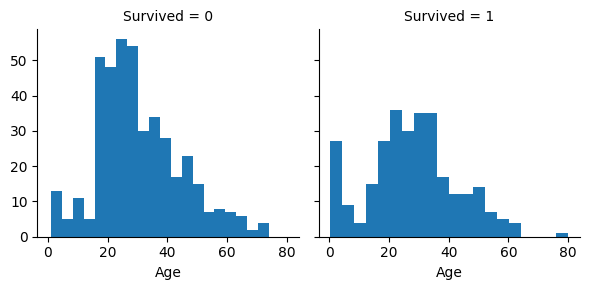

In [15]:
"""
构建一个 分面网格（FacetGrid）对象 g
col='Survived' 表示按列分面：数据会被按 Survived 的取值（0=未幸存，1=幸存）分成两份，并各画一个子图。
默认 共享坐标轴
"""
g = sns.FacetGrid(train_df, col='Survived')

"""
把 matplotlib 的直方图函数 plt.hist 映射到每个分面上
在每个子图里用当前分面的数据画 'Age' 的直方图
bins=20 把年龄区间切成 20 桶；纵轴是每个桶里的人数，横轴是年龄
缺失值会被自动忽略（NaN 不参与直方图计算）
"""
g.map(plt.hist, 'Age', bins=20)

#### Correlating numerical and ordinal features  

除了单个特征与生存率的分析，我们还可以把 多个特征放到一张图里，来更直观地确认相关性。  

---

**观察结果 (Observations)**
1. Pclass=3
    * 三等舱乘客最多，但大部分没有幸存。
    * 这验证了我们之前的假设（Classifying）。
2. 婴儿 (Age 很小) 在 Pclass=2 和 Pclass=3
    * 大多数婴儿幸存了。
    * 进一步支持了“儿童更容易幸存”的假设（Classifying）。
3. Pclass=1
    * 大部分乘客幸存。
    * 这验证了“上层阶级更容易幸存”的假设（Classifying）。
4. Pclass 与 Age 的分布
    * 不同舱位的乘客，年龄分布差异明显。
    * 例如一等舱可能更多中年和老年，三等舱更多年轻人和儿童。

---

**决策 (Decisions)**
* 在模型训练时，应当把 Pclass 作为重要特征保留

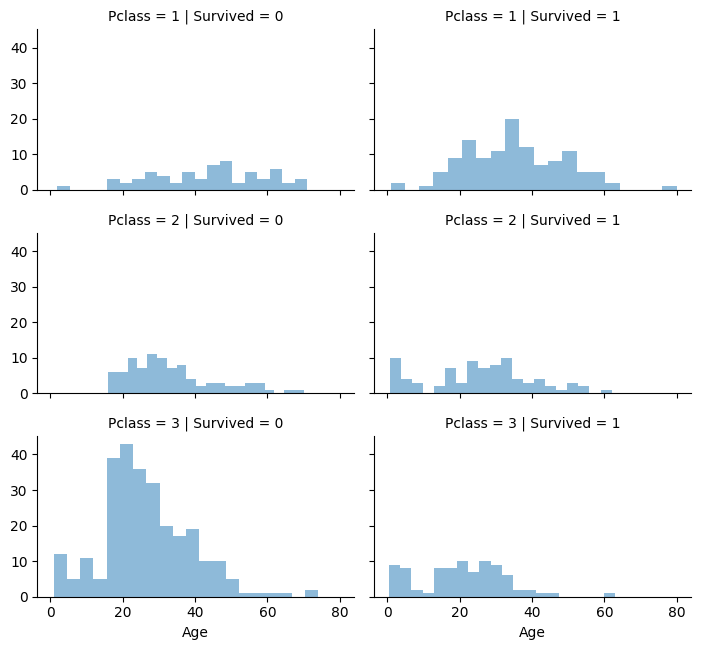

In [16]:
"""
sns.FacetGrid：创建“分面网格”对象，把同一张图分成多块小面板（facet）。
data=train_df：使用训练集。
col='Survived'：按列分面；每种 Survived 取值（0=未幸存、1=幸存）占一列 → 形成 2 列。
row='Pclass'：按行分面；每种舱位（1、2、3）占一行 → 形成 3 行。
  综上：会得到 3×2 = 6 个子图（每一格是特定 Pclass×Survived 组合下的样本）。
height=2.2、aspect=1.6：控制每个子图大小。
  height ≈ 子图高度（英寸）。
  aspect = 宽高比；每个子图宽度 = height * aspect。
"""
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=2.2, aspect=1.6)

# alpha=.5：透明度 0.5（如果将来叠加其他数据或多次 map，透明度会让重叠更易看）。
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

#### Correlating categorical features  

把分类特征（如 Sex、Embarked、Pclass）与目标 Survived 做关联分析，看看哪些特征（或它们的组合）对生存率有显著影响。  

---
**Observations**

1. 女性生存率显著更高
    * Sex=female 的生存率远高于男性，是最强的单一特征之一。
    * 解释：救生优先政策（“妇孺优先”）+ 舱位/舱室位置差异。
2. Embarked = C 出现“男性生存率更高”的例外
    * 这很可能是混杂/交互效应：C 港（Cherbourg）登船的乘客里，头等舱（Pclass=1）比例更高，而 Pclass 又与生存率强相关。
    * 因此这里看到的“Embarked ↔ Survived”表面相关，实际上可能是 Pclass 驱动 的（典型的“辛普森悖论”风险）。
    * 处理：分层分析（按 Pclass 分层比对 Embarked）、或在建模时同时纳入 Sex、Embarked、Pclass，并考虑交互。
3. 在 C/Q 港口，男性 Pclass=3 的生存率高于 Pclass=2
    * 这类“不合直觉”的现象多半来自样本量不均或分层后的极小样本。
    * 处理：查看每个分层的 样本计数 与 置信区间；样本过少的结论谨慎解读。必要时合并相近分层或用正则化模型稳住估计。
4. 不同登船港口（Embarked）在 Pclass=3、且在男性群体中，生存率差异明显
    * 说明 Embarked × Pclass × Sex 的交互对生存率有影响。
    * 处理：建模时可：
        * 直接用树模型（能自动学到交互），或
        * 在线性模型中手工加入交互项（如 Sex*Pclass、Embarked*Pclass）。

---

**决策（怎么落地）**
* 把 Sex 放进模型（强特征，必须要有）。
* 补全 Embarked 的缺失并纳入模型（可先用众数填充，或按 Pclass/Fare 条件众数填充更稳）。
* 同时保留 Pclass，并考虑与 Sex/Embarked 的交互（线性模型用交互项，树模型天然能学到）

/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:723: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


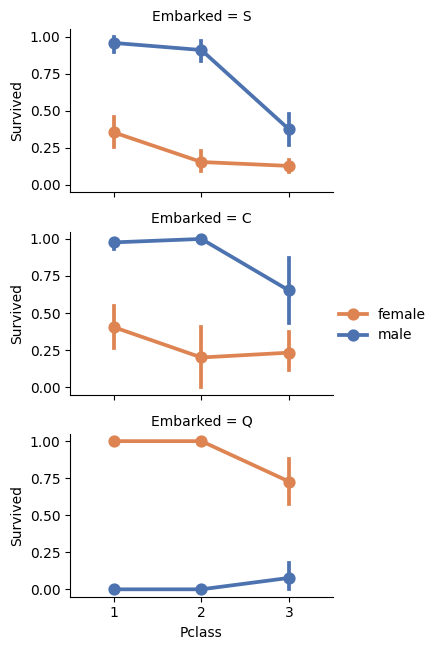

In [17]:
grid = sns.FacetGrid(train_df, row='Embarked', height=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

#### Correlating categorical and numerical features

有时候我们希望把 类别特征（categorical） 和 数值特征（numerical） 联系起来，看看它们与目标变量（Survived）的关系。

在 Titanic 数据里，可以分析：
* Embarked（登船港口，类别非数值）
* Sex（性别，类别非数值）
* Fare（票价，连续数值型）
* Survived（生存，0/1 二分类数值）  

---

**观察结果 (Observations)**

1. 票价（Fare）
    * 票价越高，乘客的生存率越高。
    * 这验证了我们的假设：需要把票价进行分段（Fare ranges），避免极端值影响。
2. 登船港口（Embarked）
    * 不同港口上船的乘客，生存率差异明显。
    * 这印证了我们之前的假设：
        * 相关性分析（Correlating） → 登船港口确实与生存率有关。
        * 补全缺失值（Completing） → Embarked 缺失值必须补全，因为这是重要特征。

---

**决策 (Decisions)**
* 对 Fare 进行分段处理（例如：低票价 / 中等票价 / 高票价），增强模型对票价与生存率关系的捕捉。
* 补全并保留 Embarked 特征，用于建模。

/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/dist-pack

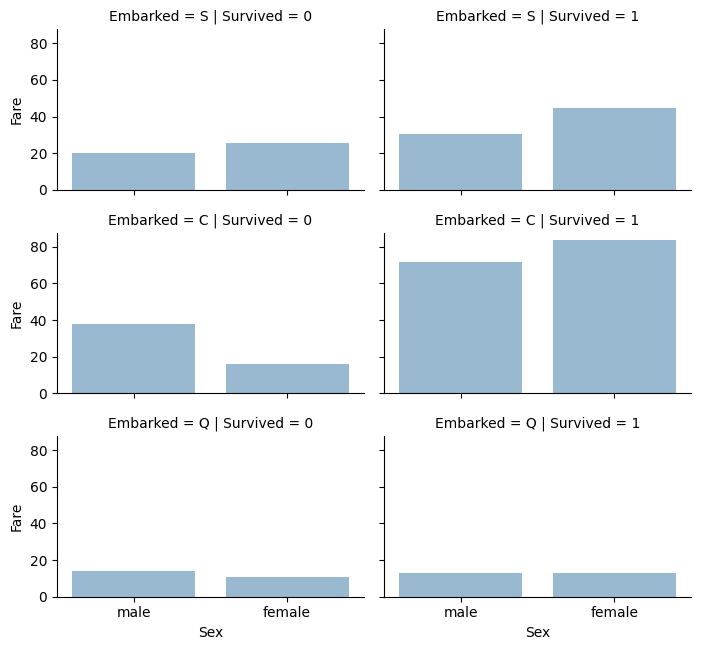

In [18]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', height=2.2, aspect=1.6)

"""
x='Sex'：横轴是性别（male / female）。
y='Fare'：纵轴是票价。
barplot 的统计逻辑：对每个类别默认计算 均值（mean）。因此柱子的高度 = 该分面中该性别的平均票价。
alpha=.5：透明度 0.5。
ci=None：不绘制置信区间

这让你直观看到：在某个港口、某个生存状态下，男女乘客的平均票价差异。
"""
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

## Wrangle data  

到目前为止，我们只是观察和分析数据，并没有真正对数据进行修改。现在开始进入 数据整理（wrangling） 阶段，把之前的假设与决策落实下来，包括：  
* Correcting（纠正）
* Creating（创建）
* Completing（补全）

### Correcting by dropping features  

这是一个很好的起点：

* 删除一些我们已经判断无用或有问题的特征。
* 这样可以让数据集更简洁，减少模型的干扰特征。
* 同时还能加快分析和训练速度。  

---

根据之前的假设和决策，要删除的特征

1. Cabin（舱位号）
    * 大量缺失值，数据太不完整。
    * 即便保留，信息也非常有限，不利于建模。
    * → 删除（Correcting）。
2. Ticket（船票编号）
    * 有很多重复值（22% 重复率）。
    * 与生存率没有明显相关性。
    * → 删除（Correcting）。

---
**注意事项**
* 在清洗时，要保证 训练集和测试集保持一致的处理。
* 所以删除特征时，要对 train_df 和 test_df 同时操作。

In [19]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

# axis=1 → 指删除的是“列”而不是“行”（行是 axis=0）
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

print("After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

Before (891, 12) (418, 11) (891, 12) (418, 11)
After (891, 10) (418, 9) (891, 10) (418, 9)


### Creating new feature extracting from existing  

特征工程（Feature Engineering） —— 从现有特征里提取有用的信息，创造新特征。  
原始数据里有一个 Name（姓名） 特征
* 姓名里面包含了 称谓（Title），比如 Mr.、Mrs.、Miss.、Master.，以及一些罕见的 Dr.、Rev.、Col. 等。
* 称谓可能和乘客的身份、社会地位、年龄段有关，从而影响 生存率。
* 用 正则表达式（RegEx） 从 Name 特征里提取称谓（Title）。
```
0   Mr.
1   Mrs.
2   Miss.
3   Master.
...
```

---
**观察结果**
* Title 与 Age 的关系：
    * 称谓基本对应了年龄段。
    * 比如 Master 通常是男孩（平均年龄约 5 岁）。
* Title 与 Survived 的关系：
    * 部分称谓和生存率高度相关：
        * Mme, Lady, Sir → 几乎全部幸存。
        * Don, Rev, Jonkheer → 大多数未幸存。
    * Mr.、Mrs.、Miss. 等称谓，生存率差异也很明显。

---
**决策**
* 保留新特征 Title 用于建模，因为它能有效区分群体并解释生存率差异。
* 后续可以 删除原始的 Name（冗余）和 PassengerId（只是编号，不影响生存）

---
**总结**
* 我们通过 特征提取（Feature Engineering） 从 Name 里抓取了称谓 Title。
* Title 和年龄、性别、社会身份相关 → 和生存率有显著关联。
* 结论：保留 Title 特征，用于后续模型训练。

In [20]:
"""
Name 是 DataFrame 里的一列（Series），类型是 object（字符串）。
.str 是 pandas 提供的字符串方法集合，让你可以对整列字符串做类似 Python 内置字符串的方法操作。
换句话说，.str 就像一个“桥梁”，让 Series 支持逐元素的字符串处理。

dataset.Name.str.extract(...)：对 Name 列做正则提取。
正则 ' ([A-Za-z]+)\.' 含义：
    前导空格 ' '：匹配名字里逗号后的空格（如 "Braund, Mr. Owen..." 中逗号后有空格）。
    [A-Za-z]+：匹配一个或多个字母（即称谓主体，如 Mr、Mrs、Miss、Master、Dr 等）。
    \.：紧跟一个点号（称谓通常写成 Mr. Mrs. 等）。
expand=False：返回 Series（不是 DataFrame），直接赋给新列 Title。
"""
for dataset in combine:
  dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

"""
d.crosstab(行, 列)：生成列联表（交叉表）。
行：Title（称谓）；列：Sex（性别）。
输出是一个计数表，显示每个称谓在男女各有多少人
"""
pd.crosstab(train_df['Title'], train_df['Sex'])

<>:7: SyntaxWarning: invalid escape sequence '\.'
<>:14: SyntaxWarning: invalid escape sequence '\.'
<>:7: SyntaxWarning: invalid escape sequence '\.'
<>:14: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-1053496430.py:7: SyntaxWarning: invalid escape sequence '\.'
  正则 ' ([A-Za-z]+)\.' 含义：
/tmp/ipython-input-1053496430.py:14: SyntaxWarning: invalid escape sequence '\.'
  dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)


Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


规范化与合并稀有称谓（Rare）

In [21]:
for dataset in combine:
  dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	    'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

  dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
  dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
  dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Title,Survived
3,Mrs,0.793651
1,Miss,0.702703
0,Master,0.575000
4,Rare,0.347826
2,Mr,0.156673


把类别型的 Title 转成有序数值（ordinal encoding）

In [22]:
"""
定义一个映射表：把文本称谓 → 映射为整数标签。
"""
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in combine:
  # .map(title_mapping)：将 Title 字符串替换成对应的数字。如果某条记录的 Title 不在字典里，映射结果会是 NaN
  dataset['Title'] = dataset['Title'].map(title_mapping)

  # .fillna(0)：把这些未匹配或缺失的情况填成 0，表示“未知/其他”。这样就不会因为 NaN 影响训练或计算
  dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


丢弃 `Name` 和 `PassengerId`

In [23]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)

# 保留 PassengerId：因为提交到 Kaggle 时需要用 PassengerId 与预测的 Survived 对应生成提交文件
test_df = test_df.drop(['Name'], axis=1)

combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

### Converting a categorical feature  
类别特征数值化，把字符串的 Sex 转成数字，便于大多数模型使用

In [24]:
for dataset in combine:
  dataset['Sex'] = dataset['Sex'].map({'female': 1, 'male': 0}).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


### Completing a numerical continuous feature

补全数值型连续特征，以 Titanic 数据集的 Age 为例  

---

**问题背景**
* Age（年龄）里有缺失值（NaN），必须补全，否则大多数模型无法直接使用。
* 目标：为缺失的 Age 提供合理估计

---

**方法对比**
1. 方法 1：简单随机法
    * 用 平均值 ± 标准差 之间的随机数来填充。

    * 好处：简单，能保持数据分布的自然性。

    * 缺点：引入随机噪声，每次运行结果可能不同。

2. 方法 2：分组中位数法（推荐）

    * 利用与 Age 有关联的特征来更准确地推测。

    * 已发现：Age 与 Sex（性别）、Pclass（舱位）相关。

    * 做法：

        * 按照 (Pclass, Sex) 分组，例如：

            * 一等舱男性 → 中位年龄 ≈ 40

            * 一等舱女性 → 中位年龄 ≈ 35

            * 三等舱男性 → 中位年龄 ≈ 25

            * 三等舱女性 → 中位年龄 ≈ 22

        * 然后用对应组的 中位数年龄 填补缺失值。

3. 方法 3：分组随机法

    * 在方法 2 的分组基础上，不用中位数，而是在 分组的均值 ± 标准差 范围内随机生成一个值。

    * 好处：更贴近真实分布。

    * 缺点：仍然会引入随机噪声，模型结果可能不稳定。

---

**结论**

* 方法 1 和 3 会引入随机性，模型结果可能随运行波动。

* 方法 2（分组中位数）更稳定、可复现，是最常用的补全策略。

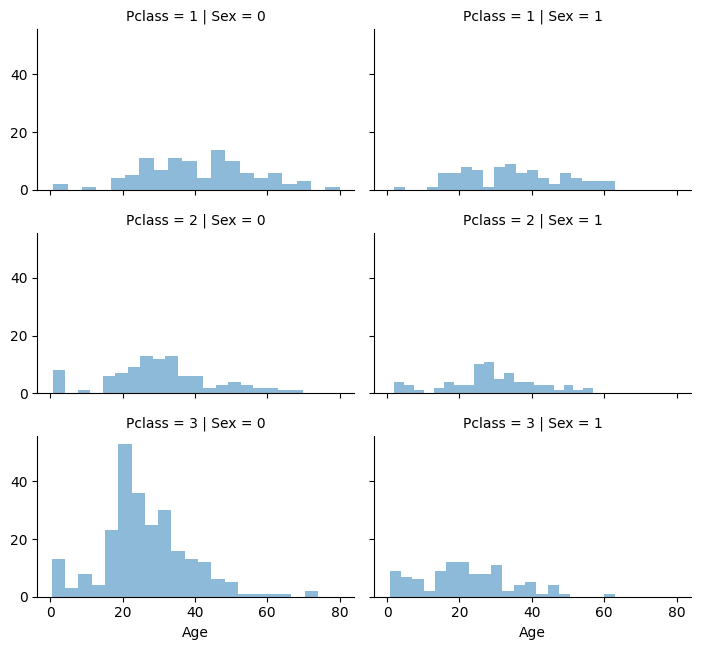

In [25]:
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

准备一个空数组用来存储 (性别 × 舱位) 六种组合下的年龄估计

In [26]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

现在我们迭代性别（0 或 1）和 Pclass（1、2、3）来计算六种组合的年龄猜测值。

In [27]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            # 先筛选出当前 (Sex=i, Pclass=j+1) 这组的 Age 列数据；
            # .dropna() 去掉 Age 里的缺失值，得到可用于估计的样本集合 guess_df
            # guess_df 类型：一个 pandas.Series（只包含年龄这一列的值）
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()

            age_guess = guess_df.median()

            # 把 age_guess 四舍五入到最接近的 0.5 岁（例如 22.3 → 22.5；22.6 → 22.5/23.0 取决于计算）
            # 存入之前准备好的 2×3 容器 guess_ages[i, j]
            guess_ages[i, j] = int( age_guess/0.5 + 0.5) * 0.5

    # 第二轮双重循环：把刚才得到的每组估计值写回到缺失处
    for i in range(0, 2):
        for j in range(0, 3):
            # 用 .loc[...] 定位到：Age 为空 且 Sex=i 且 Pclass=j+1 的行；
            # 把对应的 Age 赋值为 guess_ages[i,j]
            dataset.loc[(dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                        'Age'] = guess_ages[i, j]

    # 把 Age 列转成整数（去掉小数部分）
    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


创建年龄段并确定与生存的相关性。

In [28]:
# pd.cut(x, 5)：把连续变量 Age 按等宽切成 5 个区间（bin），返回一个有序类别（Categorical）列
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

/tmp/ipython-input-737660441.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)


,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


Replace Age with ordinals based on these bands.

In [29]:
for dataset in combine:
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


We can now remove the AgeBand feature.

In [30]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


### Create new feature combining existing features

做特征工程，通过把现有的两个特征合并生成一个新的、更有意义的特征

---
**背景**
* Titanic 数据集中有两个字段：
    * SibSp = 船上兄弟姐妹/配偶的数量
    * Parch = 船上父母/子女的数量

这两个字段分别代表了乘客随行家人的人数，但单独来看，可能信号不强。于是，我们把它们加在一起，形成一个新的特征 FamilySize。

---

**为什么要这么做？**

1. 更直观的含义：

    * FamilySize = SibSp + Parch + 1（+1 表示乘客自己）

    * 就能直接反映“这个人上船时家族的整体规模”。

2. 捕捉可能的相关性：

    * 有家人同行可能提高生存几率（互相帮助）。

    * 但如果家庭成员过多，也可能降低生存率（难以全部上救生艇）。

    * 所以这个新特征比单独的 SibSp 或 Parch 更有意义。

3. 简化数据：

    * 生成新特征后，原来的 SibSp 和 Parch 就可以删除，减少模型要处理的特征数量。

In [31]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


创建另一个 IsAlone 特征

In [32]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


删除 `Parch`, `SibSp`, `FamilySize` 用更直观的 IsAlone（是否独自一人）来替代亲属数量相关的多列，减少冗余与共线性

In [33]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


构造交互特征，把 Age 与 Pclass 合在一起，用于捕捉它们对生存率的联合作用

In [34]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


### Completing a categorical feature  

现在我们要处理一个 **类别型特征（Embarked，登船港口）** 里存在的缺失值。

---

**背景**

* Titanic 数据集的 Embarked 特征表示乘客登船港口：

    * S = Southampton（南安普顿）

    * C = Cherbourg（瑟堡）

    * Q = Queenstown（昆士敦）

* 在训练数据中，有两条记录的 Embarked 值缺失（NaN）

---

**为什么要补全？**

* 大多数机器学习模型不接受 NaN，所以必须填充。

* Embarked 是一个和生存率有关的特征（不同港口登船的乘客，阶层和生存情况有差异），随便丢弃会损失信息。

---

**处理方法**

最简单且合理的办法：

* 用出现频率最高的值（众数）来填充缺失值。

* 在 Titanic 数据里，Embarked='S' 是最常见的港口，所以缺失的两条记录都填 S。

In [36]:
"""
dropna()：先去掉缺失值，避免 NaN 影响众数计算。
mode()：求众数（出现次数最多的值）。如有并列众数，会返回多个；[0] 取第一个
"""
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [37]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


### Converting categorical feature to numeric  

**背景**

* 在 Titanic 数据里，Embarked（登船港口）是一个分类变量，取值为：

    * S（Southampton）

    * C（Cherbourg）

    * Q（Queenstown）

* 目前它还是字符串类型，但大多数机器学习算法需要数值型输入。所以我们需要把它转换成数字。

In [38]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


### Quick completing and converting a numeric feature  

快速补全并处理 Fare 特征

---

**背景**

* Titanic 数据里的 Fare（票价）是一个 数值型特征（连续型）。

* 在 测试集 中，只有 1 条记录的 Fare 缺失。

* 如果模型里有 NaN，会报错或影响结果，因此需要填补。

---

**为什么用 mode（众数）？**

* 众数 = 出现次数最多的值。

* 因为只有 1 个缺失值，用复杂方法（如按 Pclass 分组取中位数）意义不大，直接用最常见的票价就能合理补上。

* 简单、快速，不会对整体分布产生大影响。

In [39]:
# 只有 test 少了一个 fare
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

/tmp/ipython-input-1380051677.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)


,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


Now create FareBand

In [40]:
"""
pd.cut：等宽分箱（每个箱的数值范围相等），样本数可能很不均衡。
pd.qcut：等频分箱（每箱样本数接近），更适合用于比较各区间的目标均值（比如生存率）而不被样本量偏差误导。
"""
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

/tmp/ipython-input-2916669673.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)


,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


Convert the Fare feature to ordinal values based on the FareBand.

In [41]:
for dataset in combine:
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]

train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


In [42]:
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3
5,897,3,0,0,1,0,1,1,0
6,898,3,1,1,0,2,2,1,3
7,899,2,0,1,2,0,1,0,2
8,900,3,1,1,0,1,3,1,3
9,901,3,0,1,2,0,1,0,3


## Modeling

接下来要开始真正训练模型并进行预测了。

1. 问题性质

    * 这是一个 监督学习 (Supervised Learning) 的问题，因为我们有带标签的数据（即 Survived 是否存活）。
    * 目标是做 分类 (Classification)，因为输出变量是二元：存活(1) 或 未存活(0)。
    * 有时候也会提到“回归 (Regression)”方法，因为一些模型既能做分类也能做回归。

2. 输入与输出
    * 输出 (y)：Survived (存活与否)。
    * 输入 (X)：乘客的性别、年龄、舱位、登船港口等特征。

3. 模型候选
因为这是 分类问题，所以常见的候选模型有：
    * **Logistic Regression**（逻辑回归）：简单、可解释性强。
    * **KNN** (k-近邻)：基于距离度量，直观但计算量大。
    * **SVM** (支持向量机)：在高维特征下表现强大。
    * **Naive Bayes** (朴素贝叶斯)：对小数据、独立假设问题常有效。
    * **Decision Tree** (决策树)：规则清晰、易解释。
    * **Random Forest** (随机森林)：集成学习，通常效果比单棵树好。
    * **Perceptron** (感知机)：最简单的神经网络模型。
    * **ANN** (人工神经网络)：更复杂的深度学习结构。
    * **RVM** (相关向量机)：与SVM类似，但使用贝叶斯方法。

4. 总结

所以可以依次尝试这些模型，在训练集上拟合，在测试集上预测，比较准确率（或其他指标），选择最优模型提交

In [46]:
# 这里的 .drop() 默认参数 inplace=False，意思是返回一个删除了指定列的新 DataFrame，
# 但不会修改原始的 train_df
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]

# 加 .copy() 只是为了显式拷贝，避免后续链式赋值警告或无意修改原表
X_test = test_df.drop("PassengerId", axis=1).copy()

X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

### Logistic Regression  

1. 为什么先用逻辑回归  
逻辑回归是一个非常经典、简单的二分类模型（0/1）。  
    * 它计算的是某个事件发生的概率（比如乘客存活的概率）。
    * 在 Titanic 问题里：输出 `Survived` (0=未存活，1=存活)，输入是性别、年龄、舱位等特征。
    * 因为简单易用、计算快、解释性强，所以通常在建模的早期就会先跑它，快速得到一个基准性能。

---

2. 逻辑函数（Logistic Function）  
逻辑回归不是直接输出 0 或 1，而是先计算一个线性组合：

$$
z=w_0+w_1x_1+w_2x_2+...+w_nx_n
$$

再通过 Logistic 函数（S 型函数，Sigmoid 函数） 转换为概率：

$$
P(y=1|X)=\frac{1}{1+e^{-z}}
$$

这个值就在 0~1 之间，可以理解为“存活的可能性”。

---

3. 置信度（Confidence Score）  
当你用训练好的逻辑回归模型去预测时，模型不仅会给出预测标签（0 或 1），还会给出一个 概率值：

    * 如果 P ≥ 0.5，就预测为 1（存活），否则预测为 0。

    * 这个概率值就是所谓的 confidence score（置信度/概率分数），表示模型对预测的信心。

    例如：

    * Passenger A → 存活概率 0.82 → 预测为 1（存活），置信度 82%。

    * Passenger B → 存活概率 0.21 → 预测为 0（未存活），置信度 21%。

In [47]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
# 对测试集做类别预测（0/1 标签），注意这里得到的是标签，不是概率。
Y_pred = logreg.predict(X_test)

# score 在分类任务中默认是准确率（accuracy）。这行把训练集准确率 ×100 变成百分比并保留 2 位小数。
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
# 逻辑回归在训练集上的准确率（%）
acc_log

81.37

解释 逻辑回归模型系数（coefficients） 如何帮助我们验证之前做的特征工程决策  

1. 系数的意义

    * 正系数：特征值越大，样本属于 Survived=1（存活）的概率越大。

    * 负系数：特征值越大，样本属于 Survived=1 的概率越小。
    * 换句话说，系数衡量了特征对存活几率的影响方向和强度。

2. 具体特征解读

    * Sex（性别）
        * 系数最大、为正。说明当 Sex 由 0（男）→ 1（女）时，存活概率显著增加。符合泰坦尼克背景的“女士优先”。

    * Pclass（船舱等级）
        * 系数为负，且影响很大。说明 Pclass 数值越高（1等舱=1，3等舱=3），存活概率越低。即头等舱更安全，三等舱风险最大。

    * Age*Class（人工构造特征）
        * 系数为负，且影响仅次于 Pclass。说明“年龄大 × 舱位差”会显著降低存活概率，这个交互特征确实有意义。

    * Title（称谓，例如 Mr, Mrs, Miss 等）
        * 系数为正，仅次于 Sex。说明称谓（反映身份/社会地位）和存活概率有很大关系。

3. 结论  
通过查看逻辑回归的系数，我们可以确认：

    * 性别、舱位的确是最重要的影响因素；

    * 人工构造的 Age*Class 和 Title 特征确实提升了模型解释力；

    * 这也证明了前面“删掉多余列、创造新特征”的思路是正确的。

In [49]:
"""
train_df.columns.delete(0)：把 train_df 的列名拿出来，但删除第 0 个（一般是 Survived，因为它是目标列，不是特征）。
pd.DataFrame(...)：把这些列名变成一个 DataFrame，默认列名是 0。
结果：一张只有一列（特征名）的 DataFrame。
"""
coeff_df = pd.DataFrame(train_df.columns.delete(0))

# 把这一列的列名改成 'Feature'，更直观
coeff_df.columns = ['Feature']

"""
logreg.coef_[0]：逻辑回归学到的系数（对应每个特征的权重）。
pd.Series(...)：转成一列数据。
给 coeff_df 增加一列 "Correlation"，存放每个特征对应的系数值。
"""
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.201033
5,Title,0.406095
4,Embarked,0.276739
6,IsAlone,0.185767
7,Age*Class,-0.050246
3,Fare,-0.071894
2,Age,-0.469586
0,Pclass,-1.200216


### Support Vector Machines

1. SVM 是什么  
    * **SVM（支持向量机）** 是一类 监督学习模型，常用于分类和回归。

    * 它的基本思想是：

        * 给定训练样本（如存活/未存活），SVM 会找到一个 最优超平面 (hyperplane)，把不同类别的数据尽量分开。

        * “最优”的含义是——让两个类别之间的 间隔 (margin) 最大化。

    * 在二分类问题中，SVM 会学习一个模型，把新样本分到 0（未存活） 或 1（存活）。

2. 特点

    * 非概率型：与逻辑回归不同，SVM 本质上不是输出概率，而是输出类别（有的实现可以通过校准来给出概率）。

    * 强分类能力：SVM 在高维空间中表现非常好，尤其适合复杂边界的数据。

    * 核函数 (Kernel Trick)：SVM 可以通过核函数（线性、多项式、RBF 等）处理非线性数据，把原本不可分的数据转化为可分。

3. 置信度（Confidence Score）

    * SVM 的 decision_function 或 predict_proba 可以给出一个 “距离超平面的远近”，这个值越大，说明模型越有把握样本属于某个类别。

    * 在泰坦尼克建模中，通常会看到 SVM 的置信度比逻辑回归高，说明它在划分类别时边界更清晰。

In [50]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

82.83

### KNN  

1. KNN 是什么  
    * 非参数方法 (non-parametric)：它没有显式的模型或公式，而是直接依赖训练数据。
    * 原理：
        * 对一个新的样本，找到训练集中与它最接近的 k 个邻居。
        * 通过投票决定类别：哪个类别的邻居多，新样本就属于哪个类别。

    * 举例：

        * 如果 k=1，新样本直接归类为最近邻的类别。

        * 如果 k=5，则看最近的 5 个样本中多数是什么类别。

2. KNN 的特点  
    * 直观：靠“相似度”判断分类。

    * 懒惰学习 (Lazy learning)：没有训练过程，只是存储数据，预测时才计算距离 → 预测较慢。

    * 对特征尺度敏感：需要归一化或标准化特征，否则“距离”会失真。

    * k 的选择：小 k → 模型复杂，容易过拟合；大 k → 平滑，可能欠拟合。

3. 置信度（Confidence Score）

    * 在 KNN 中，置信度可以理解为：在 k 个邻居里，属于某一类别的比例。

        * 例如 k=5，若 4 个邻居存活，1 个未存活 → 存活概率 80%。

    * 在泰坦尼克任务中：

        * KNN 的置信度通常比逻辑回归高，因为它基于实际邻居投票，更贴合局部数据分布。

        * 但 KNN 的置信度比不上 SVM，因为 SVM 构建了“最大间隔”的分界面，分类边界更清晰。

In [51]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)

acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

83.73

### Naive Bayes  
1. 朴素贝叶斯是什么  
    * 属于 概率模型，基于 贝叶斯定理 (Bayes’ Theorem)：

$$
P(Y|X)=\frac{P(X|Y)P(Y)}{P(X)}
$$

“朴素”假设：所有特征彼此独立（实际上在现实中并不完全独立，但这种简化能让计算更高效）。

因此，计算时只需把各特征的条件概率相乘，就能得到整体概率。

2. 特点

    * 简单高效：参数数量随特征数线性增长，所以很适合高维数据（比如文本分类）。

    * 可扩展性强：计算量小，训练预测速度快。

    *  独立性假设过强：现实数据里特征往往相关，这会让模型效果受限。

    * 适合场景：垃圾邮件过滤、情感分析等。

3. 置信度（Confidence Score）

    * 朴素贝叶斯输出的是概率分布，但由于独立性假设过于强烈，它计算出来的概率往往 偏离真实概率。

    * 在 Titanic 任务中：

        * 它的置信度分数最低，说明模型在区分“存活/未存活”时不如前面用的 逻辑回归、KNN、SVM。

        * 不过，它训练快、实现简单，因此常作为一个 基准模型。

In [52]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)

acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

76.88

### Perceptron  

感知机是最早的 二分类监督学习算法，可以判断一个样本是否属于某个类别。

本质上是一个 线性分类器：

它通过一个线性函数（权重 * 特征 + 偏置）来决定分类。

如果结果大于某个阈值，就判定为一类，否则判定为另一类。

In [54]:
# Perceptron
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

79.35

In [55]:
# Linear SVC
"""
SVC 是 SVM 的分类器实现。它可以选择不同的核函数（kernel）来处理线性或非线性问题。
当数据量大、特征数多时，用 线性核 (Linear Kernel) 更高效。
LinearSVC 在 sklearn 中是专门为 线性分类 提供的快速实现，相比 SVC(kernel="linear") 更快更省内存。
适合像 Titanic 这样数据量不算太大、特征经过预处理的二分类任务。
"""
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

79.46

In [57]:
# Stochastic Gradient Descent
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)

acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

79.91

### Decision Tree  

1. 决策树是什么

    * 决策树是一种预测模型，用树形结构来表示：

        * 分支 (branch)：特征的判断条件（例如 Age < 16?）。

        * 叶子 (leaf)：最终的预测结果（例如 Survived=1 或 Survived=0）。

    * 它的过程就像“20 个问题”游戏：根据特征一步步提问，最终得出分类结果。

2. 分类树 vs 回归树

    * 分类树 (Classification Tree)：目标变量是离散的，比如 Titanic 的 Survived（0/1）。

    * 回归树 (Regression Tree)：目标变量是连续的实数，比如预测房价。

3. 模型特点

    * 直观、可解释：树可以画出来，每一步的决策逻辑清晰可见。

    * 能处理非线性关系：不像逻辑回归或线性 SVM 只能拟合直线边界。

    * 容易过拟合：如果树太深，可能过度拟合训练集 → 需要剪枝、设置最大深度等参数。

4. 置信度（Confidence Score）

    * 决策树的置信度可以理解为：在某个叶子节点中，训练样本属于某一类的比例。

    * 在 Titanic 数据上：

        * 决策树的置信度最高，说明它在训练集上分类得非常精确。

        * 但要注意，这种“高分”可能是因为过拟合（记住了训练数据），所以在测试集上不一定表现最好。

In [58]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)

acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

86.64

### Random Forests  

1. 随机森林是什么

    * 随机森林是一种 集成学习方法 (Ensemble Learning)，它不是只建一棵树，而是建很多棵决策树（默认 100 棵，n_estimators=100）。

    * 工作原理：

        * 在训练时，每棵树会用 不同的样本子集 和 部分特征子集 来训练（引入随机性）。

        * 预测时：

            * 分类任务 → 看所有树的投票结果，取多数类（mode）。

            * 回归任务 → 取所有树预测值的平均数（mean）。

2. 特点

    * 比单棵决策树更稳健：避免过拟合，因为它通过“多棵树投票”来平滑单棵树的极端判断。

    * 泛化能力强：对未知数据预测效果更好。

    * 可扩展性强：可以通过增加树的数量提升性能，但计算量也随之增加。

3. 在 Titanic 问题中的表现

    * 随机森林结合了多棵树的优势 → 准确率和置信度通常最高。

    * 因此在建模比较里，它的分数往往超过逻辑回归、SVM、KNN 等。

    * 这就是为什么这里决定使用 随机森林的预测结果 (Y_pred) 作为最终提交到 Kaggle 竞赛的答案。

In [59]:
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

86.64

## Evaluation

1. 模型评估 (Model Evaluation)  
    * 前面我们训练了多个模型：逻辑回归、SVM、KNN、朴素贝叶斯、感知机、线性 SVC、决策树、随机森林……

    * 然后分别计算了它们在训练集上的准确率（或置信度），进行比较排序。

    * 结果显示：决策树和随机森林的得分相同，都是最高分。

2. 为什么不用决策树

    * 单棵 决策树很容易 过拟合：

        * 它可能记住了训练数据里的细节，导致在新数据（测试集）上表现变差。

        * 这种“过拟合”是决策树的常见问题。

3. 为什么选择随机森林

    * 随机森林通过集成多棵树（每棵树训练时使用不同的数据子集和特征子集）：

        * 能有效降低过拟合。

        * 预测时依靠多数投票（分类）或平均值（回归），结果更稳健。

    * 因此，虽然分数和决策树一样，但它泛化能力更强，在实际竞赛提交时更可靠。

In [60]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression',
              'Random Forest', 'Naive Bayes', 'Perceptron',
              'Stochastic Gradient Decent', 'Linear SVC',
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log,
              acc_random_forest, acc_gaussian, acc_perceptron,
              acc_sgd, acc_linear_svc, acc_decision_tree]
})

models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,86.64
8,Decision Tree,86.64
1,KNN,83.73
0,Support Vector Machines,82.83
2,Logistic Regression,81.37
6,Stochastic Gradient Decent,79.91
7,Linear SVC,79.46
5,Perceptron,79.35
4,Naive Bayes,76.88


In [61]:
submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],
    "Survived": Y_pred
})

submission.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [62]:
submission.to_csv("submission.csv", index=False)

Export as HTML

In [63]:
from google.colab import drive
drive.mount('/content/drive')

!ls -lah "/content/drive/My Drive/Colab Notebooks/Machine Learning/Titanic Project"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
total 575K
drwx------ 2 root root 4.0K Oct  2 12:01 data
-rw------- 1 root root 571K Oct  3 04:56 Titanic.ipynb


In [64]:
!jupyter nbconvert --to html "/content/drive/My Drive/Colab Notebooks/Machine Learning/Titanic Project/Titanic.ipynb" \
  --output "/content/Titanic.html"

from google.colab import files
files.download("/content/Titanic.html")

[NbConvertApp] Converting notebook /content/drive/My Drive/Colab Notebooks/Machine Learning/Titanic Project/Titanic.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 817103 bytes to /content/Titanic.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>